**The goal and motivation of this notebook**  

When training DNN models using spectrogram, I tried various data augmentations, but there was only a slight improvement in both LB and CV. Therefore, as an alternative, I tried to expand it by random sampling when [creating EEG Spectrograms](https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg).  
I thought about creating a spectrogram from all the eeg data and then doing random sampling, but I decided that the amount of data would be too large and would be difficult to read.

The eeg parquet files have various lengths, and the original EEG specs are only data for the middle 50 seconds, so I thought random sampling would be effective.I think this technique may also work for kaggle_specs. Regarding kaggle_specs, I will try reducing the sampling width from 10 mins to 50 seconds and then perform random sampling.    
I haven't verified whether this is the right approach yet, but I'm posting this to get feedback from kagglers. Please feel free to comment if you like!   
 
Please also upvote if it helps 

**Rough steps for random sampling**
1. Group the df by eeg_id and expert_consensus.  
Since there is data with different conclusions even within the same eeg_id, the characteristics may change depending on the observation time even within a unique eeg parquet file. -> I decided that it should be treated as separate data.

2. Create observation time for each group in seconds.   
the observation time for a single conclusion is not necessarily continuous because there is data in which the conclusion changes in the middle of the electroencephalogram data.  
  
3. From each observation data, a total of 50 seconds is acquired by random sampling using three time windows.  
The length of the time window is randomized and adjusted so that the total time window is 50 seconds. Each acquired element should not be duplicated.    

4. Create multiple samples depending on the data length. (Increase the number of items created for long observation times)  
Overlapping with another random sampling from the same eeg  

Conditional branching on data length:
* 50 - 100 (seconds)...Create one sampling data
* 100 - 150 (seconds)...Create 2
* 150 - 200 (seconds)...Create 3
* 200~ (seconds)...Create 4


5. Create spectrograms from the acquired eeg data. The created specs are labeled with eeg_id, expert_consensus, and dup_count (duplication count).  


**[Here](https://www.kaggle.com/datasets/suzukisatsuki/eeg-spectrogram-by-extended-data) is the dataset I created**

**このノートブックの動機と目的**  

spectrogramを用いたDNNモデルの訓練において、様々なData Augmentationを試行しましたがLB,CVともにわずかな向上のみでした。そこで、代替案として[EEG Spectorgramsの作成](https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg)の際にrandom samplingによる拡張を試みました。  
全ての脳波データを利用してeeg_spectrogramsを作成してからランダムサンプリングをすることも考えましたが、データ量が膨大になる可能性を考えて今回は観測時間からサンプルを取得した後にspectrogramを作成しました。    

この試みは、それぞれのeeg parquetファイルが持つデータの長さが一意でなく、かなりのばらつきがあることと、元のEEG Specsは各ファイルの真ん中50秒のみにフォーカスしたデータであることから有用な方法ではないかと判断しました。この手法はkaggle_specsに対しても有効な可能性があると考えています。kaggle_specsに関してはサンプリングの幅を10分から50秒に縮小するなどしてから試行しようと思います。  
これが正しいアプローチかはまだ検証できていませんが、kagglerの皆さんに意見を頂戴したいと思い投稿しました。もしよければぜひコメントしてください！ 

役に立った場合、良ければupvoteしていただければ励みになります！

**randam samplingの大まかな手順**
1. データをeeg_idとexpert_consensusでグループ化する。  
※同一eeg_id内でも結論の異なるデータが存在するため、一意のeeg parquet file内でも観測時刻によって特徴が変化すると思われる。＝＞別個のデータとして切り分けるべきだと判断しました。  

2. グループごとに観測時間を秒ごとに作成。  
これは脳波データの途中で結論が変更されるデータが内在しているため、単一の結論の観測時間が必ず連続であるとは限らないためである。  

3. 上記の処理によってグループごとに長さの異なる観測時間が取得できる。それぞれのデータから、3つの時間窓を用いてランダムサンプリングによって合計50秒のデータを取得。  
※同一eeg file内で複数のspec作成の際はサンプリングごとの重複は許すようにしました。  
  
4. データ長に応じて複数のサンプリングを行う。（観測時間が長いものに対して作成個数を増やす）  
※時間窓の長さはランダムかつ時間窓の合計が50秒になるように調整。時間窓の取得要素は重複しないようにする。   

データ長の条件分岐：  
* 50～100(秒)・・・1つのサンプリングデータ作成  
* 100～150（秒）・・・2つ作成  
* 150～200（秒）・・・3つ作成  
* 200～（秒）・・・4つ作成  


5. 取得したeeg dataより、spectrogramを作成。作成したspecsはeeg_idとexpert_consensus、dup_count(重複回数)でラベリング。  

作成したdatasetは[こちら](https://www.kaggle.com/datasets/suzukisatsuki/eeg-spectrogram-by-extended-data)です。

In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, gc

SAVE_INDIVIDUAL_EEGS = False
SAVE_EEGS = False

df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape', df.shape )
display( df.head() )

pd.set_option('display.max_columns', None)

Train shape (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# step1 , 2
**step1 : Group train_df by eeg_id and expert_consensus**  
**step2 : Create observation time for each group in seconds**


In [2]:

# 各行に対して観測時間の連続値と重複カウントを取得
train = df.copy()
train['dup_count'] = train.groupby(['eeg_id', 'expert_consensus']).cumcount()
train['observation_time'] = train['eeg_label_offset_seconds'].apply(lambda x: list(range(int(x),int(x)+50)))

# 「expert_consensus, eeg_id」でグルーピングして、グループごとに「observation_time」の和集合を取得
elapsed_df = train.groupby(['expert_consensus', 'eeg_id'])['observation_time'].apply(lambda x: list(set().union(*x))).reset_index()

# 観測の合計時間を算出
elapsed_df['length_t'] = elapsed_df['observation_time'].apply(lambda x: len(x))

# trainに観測時間、観測時間の長さを結合
train = train.iloc[:,:-1].merge(elapsed_df, on=['expert_consensus', 'eeg_id'], how='left')

# targetsをグループごとに足し合わせてから正規化
tmp = df.groupby(['eeg_id','expert_consensus'])[TARGETS].agg('sum').reset_index()
train = train.drop(columns=TARGETS).merge(tmp, on=['eeg_id','expert_consensus'], how='left')

y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

train.reset_index(drop=True, inplace=True)

elapsed_df.head()

,expert_consensus,eeg_id,observation_time,length_t
0,GPD,751790,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",50
1,GPD,4454049,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",88
2,GPD,9859330,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",66
3,GPD,12197246,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",70
4,GPD,25408618,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",50


Text(0.5, 0, 'dup cumsum count')

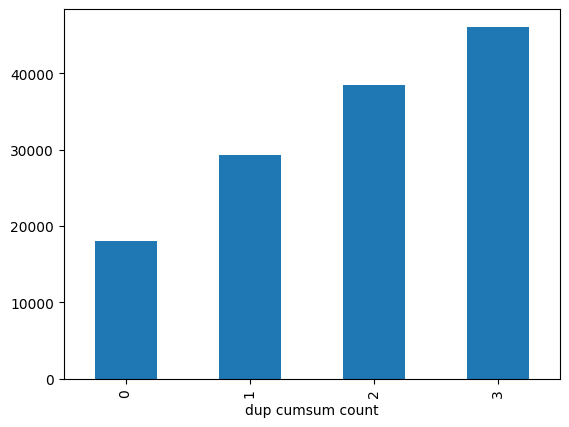

In [3]:
# ３つまで重複を許した時のデータ量の推移
# Change in data amount when up to 3 duplications are allowed

train_ = train.copy()
train_ = train_[train_['dup_count']<= 3]
train_['dup_count'].value_counts().cumsum().plot(kind='bar')
plt.xlabel('dup cumsum count')

* The above trends are contained all duplicate rows, regardless of observation time.  
* Add conditional extraction regarding length_t to the above duplication.  
(The longer the observation time, the more duplication will be adjusted.)  
  
※上の推移は観測時間によらず全ての重複行を足し合わせた数である。  
　ランダムサンプリングによるデータの拡張を効果的にしたいので、上記の重複に対してlength_tについての条件抽出を加える  
（観測時間が長いほど、重複を許容するように調整する。）

train shape is :  (22774, 18)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,dup_count,observation_time,length_t,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",90,1.0,0.0,0.000000,0.0,0.000000,0.000000
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",52,0.0,0.0,0.454545,0.0,0.090909,0.454545


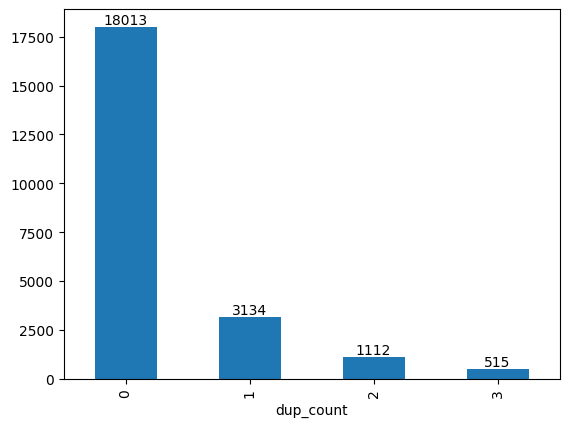

In [4]:
# 「length_t」が50～100（未満）の時、重複はなし
train =train[~((train['length_t']>=50) & (train['length_t']<100) & (train['dup_count']>0))]

# 「length_t」が100～150（未満）の時、重複を1度許容する
train =train[~((train['length_t']>=100) & (train['length_t']<150) & (train['dup_count']>1))]

# 「length_t」が150～200（未満）の時、重複を2度許容する
train =train[~((train['length_t']>=150) & (train['length_t']<200) & (train['dup_count']>2))]

# 「length_t」が200以上の時、重複を3度許容する
train =train[~((train['length_t']>=200) & (train['dup_count']>3))]

print('train shape is : ', train.shape)

# 重複回数ごとのデータ量を可視化
train['dup_count'].value_counts().plot(kind='bar')
for i, value in enumerate(train['dup_count'].value_counts().sort_index()):
    plt.annotate(str(value), xy=(i, value), ha='center', va='bottom')
train.head(2)

In [5]:
# # データ内にどの程度観測結果の異なるeeg_idが存在するか確認
# data = elapsed_df.groupby(['eeg_id'])['expert_consensus'].nunique()
# print('Multi targets eeg_ids:', len(data[data>1]))

# step3 : Create a function for random_sampling( +Visualazation)

In [6]:
# randam_sampling用の関数作成
# サンプリングの対象は、各グループの全観測時間の配列であり、非連続な観測時間の配列にも対応

import numpy as np

def random_sampling(time_series, total_width, num_windows):
    sampled_windows = []
    
    for window in range(num_windows):
    
        # ランダムに時間窓の幅を選ぶ
        if window == num_windows-1 or total_width<=15:
            window_width = total_width
        else:
            window_width = np.random.randint(5, 16)
            
        # 開始位置をランダムに選ぶ
        start_index = np.random.randint(0, len(time_series) - window_width + 1)
        # 選択された時間窓を追加
        sampled_windows.append(time_series[start_index : start_index + window_width])
        
        # 選択された時間窓に対応する部分を元のデータから削除
        time_series = np.delete(time_series, range(start_index, start_index + window_width))
        # 合計時間窓の幅を調整
        total_width = total_width - window_width
        
    # 配列を結合、昇順に並べなおす
    sampled_windows = np.sort(np.concatenate(sampled_windows, axis=0))
    
    return sampled_windows


In [7]:
# # 仮の時系列データを作成
# time_series_data = np.arange(1000)

# # 合計が50になるようなランダムな時間窓を4つサンプリング
# sampled_windows = random_sampling(time_series_data, total_width=50, num_windows=4)

# # # 結果を表示
# # for i, window in enumerate(sampled_windows):
# #     print(f"Time Window {i + 1}: {window}")
# plt.plot(sampled_windows)

In [8]:
# ランダムサンプリングの可視化(expert_consensusを複数持つ脳波データを可視化)
import matplotlib

# 複数のconsensus持つ脳波データの中で、対応する適当なeeg_idを取得
eeg_ids = elapsed_df.groupby(['eeg_id'])['expert_consensus'].nunique()
multi_cons_id = np.random.choice(eeg_ids[eeg_ids>1].index.to_list())

sample_eeg = multi_cons_id
# ファイルをdfとして取得
eeg_df = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{multi_cons_id}.parquet')

In [9]:
# # 全観測時間が100秒を超えるeegの可視化
# eeg_ids = elapsed_df[elapsed_df['length_t']>= 100]['eeg_id'].unique()
# sample_eeg = np.random.choice(eeg_ids)
# eeg_df = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{sample_eeg}.parquet')
# sample_eeg

observation range:  416
[104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 344 345 346
 347 348 349 350 351 352 407 408 409 410 411 412 413 414]
sample_size:  10000
observation range:  82
[218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 264 265 266 267 268 269 270 271]
sample_size:  10000


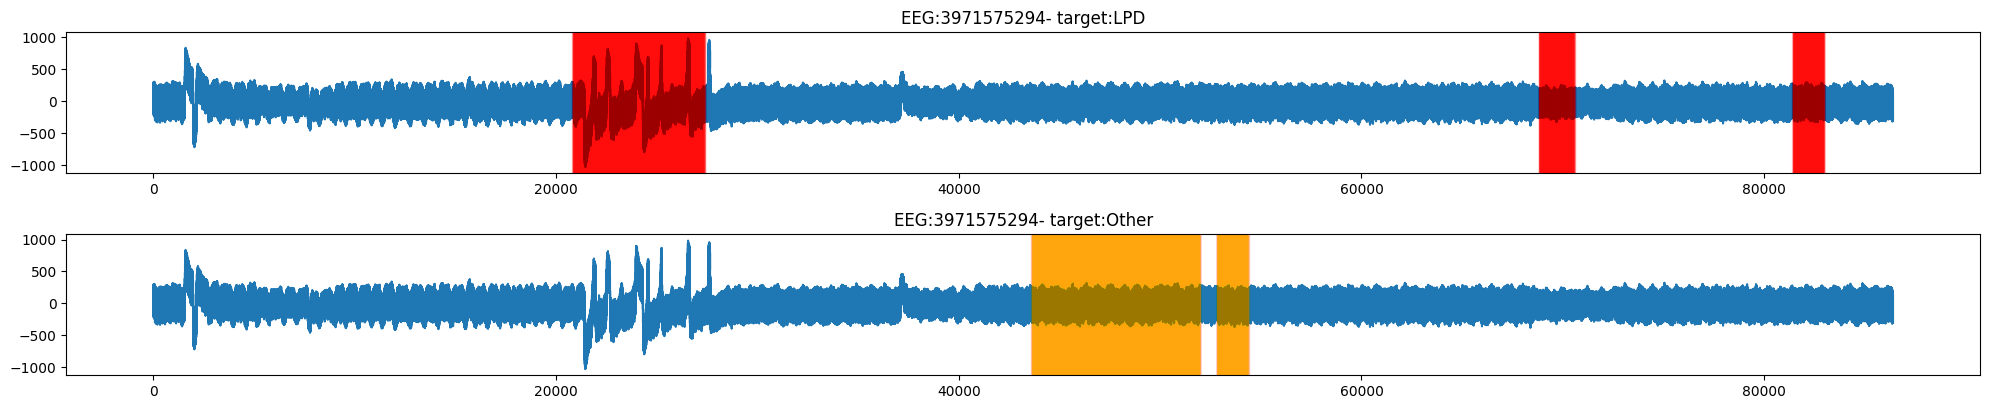

In [10]:
plt.figure(figsize=(20,8))

colors = ['red', 'orange', 'yellow', 'green', 'white', 'blue', 'black']

# 「eeg_id,expert_consensus」でグループ化された適当なデータからのランダムサンプリングを実行して可視化
for i, (_, row) in enumerate(elapsed_df[elapsed_df['eeg_id']==sample_eeg].iterrows()):
    
    plt.subplot(4,1,i+1)
    eeg_df['Fp1'].plot()    #任意の特徴量を描画
    
    data = np.array(row['observation_time'])   # 観測時間をnumpy配列で表現
    print('observation range: ', len(data))
    target = row['expert_consensus']

    # 最大3つの時間窓（長さはランダム）で観測時間を取得
    window = random_sampling(data, total_width=50, num_windows=3)
    print(window)
    indices = np.concatenate([np.arange(ind*200, (ind+1)*200) for ind in window],axis=0)
    print('sample_size: ', len(indices))
    
    for index in indices:
        plt.axvline(x=index, color=colors[i],linestyle='-',alpha=0.02,
                linewidth=1,)
    plt.title(f'EEG:{sample_eeg}- target:{target}')

plt.tight_layout()
plt.show()

**Note: Although I wrote that there are a maximum of three time windows, the number of consecutive time windows after sampling may be four or more.**  
(Because in a single time window, it is possible to obtain a list of non-consecutive observation times.)  

**注意点：時間窓が最大3つと書きましたが、サンプリング後の連続する時間幅の個数は4つ以上になる可能性もあります。**  
（単一の時間窓で、非連続な観測時間のリストを取得する可能性があるためです。）

# step4 : Create multiple samples depending on the data length

In [11]:
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

In [12]:
import pywt
print("The wavelet functions we can use:")
print(pywt.wavelist())

USE_WAVELET = None #or "db8" or anything below

The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

In [13]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

In [14]:
 
import librosa

def spectrogram_from_eeg(row, display=False):
    
    dir_path = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
    eeg_id = row['eeg_id']
    parquet_path = os.path.join(dir_path, f'{eeg_id}.parquet')
    
    data = np.array(row['observation_time'])
    window = random_sampling(data, total_width=50, num_windows=3)
    indices = np.concatenate([np.arange(ind*200, (ind+1)*200) for ind in window],axis=0)
    
    target = row['expert_consensus']
    dup_count = row['dup_count']
    
    eeg = pd.read_parquet(parquet_path)
    eeg = eeg[eeg.index.isin(indices)]

#     if offset is None:
#         middle = (len(eeg)-10_000)//2
#         eeg = eeg.iloc[middle:middle+10_000]
#     else:
#         eeg = eeg.iloc[offset:offset+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean() < 1: 
                x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id}-{target}-{d_count} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id}-{target}-d{dup_count} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

print("The wavelet functions we can use:")
print(pywt.wavelist())

The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

# step5 : Create spectrograms from the acquired eeg data

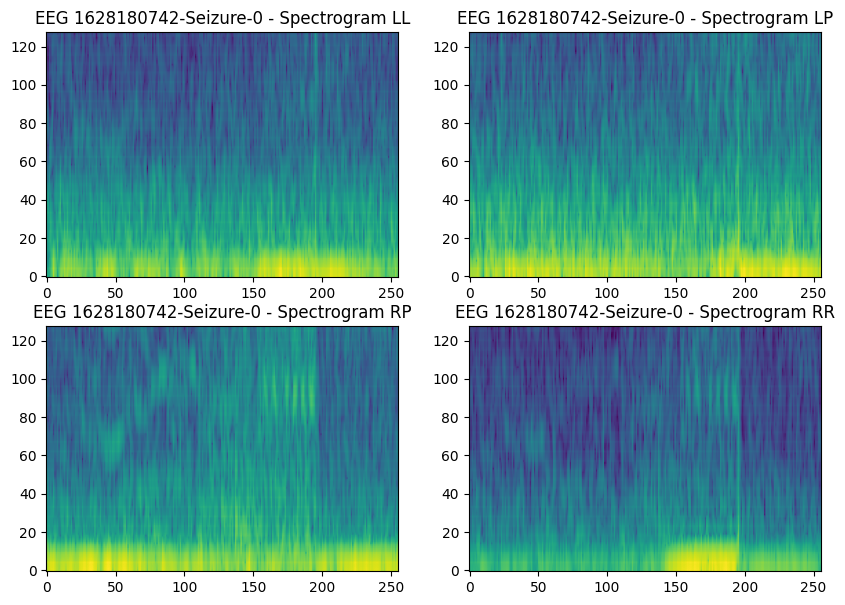

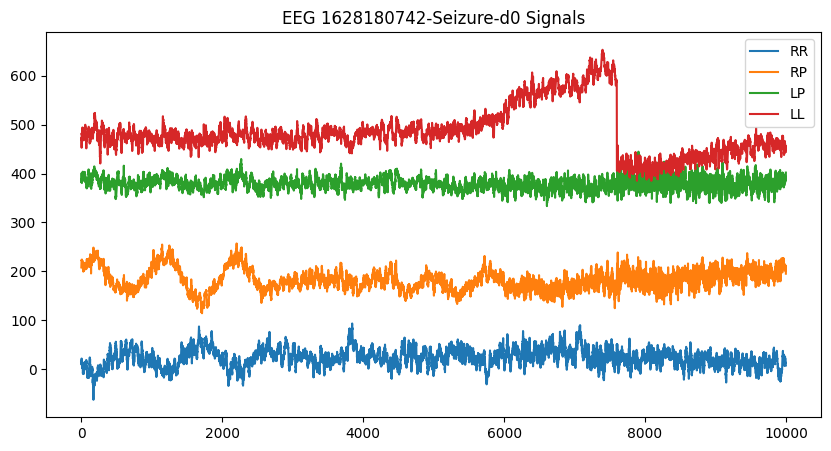


#########################



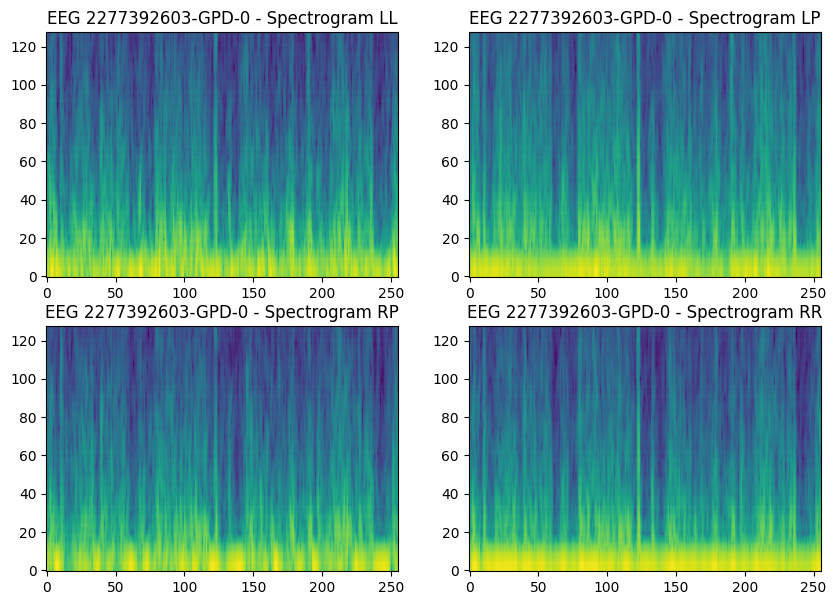

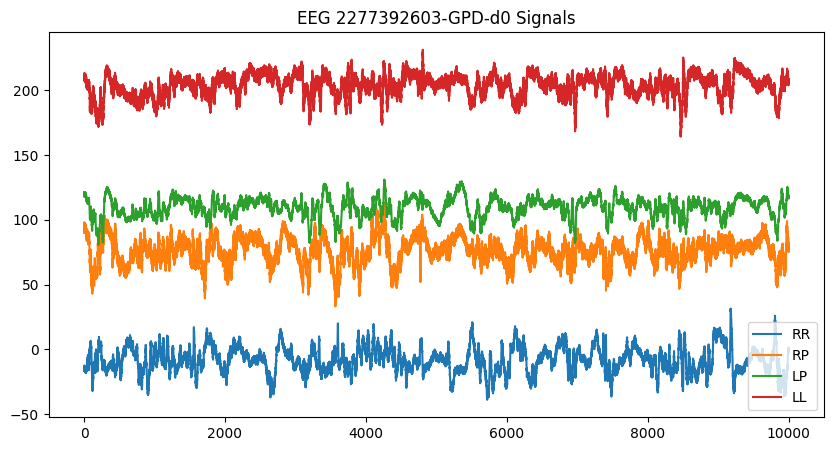


#########################



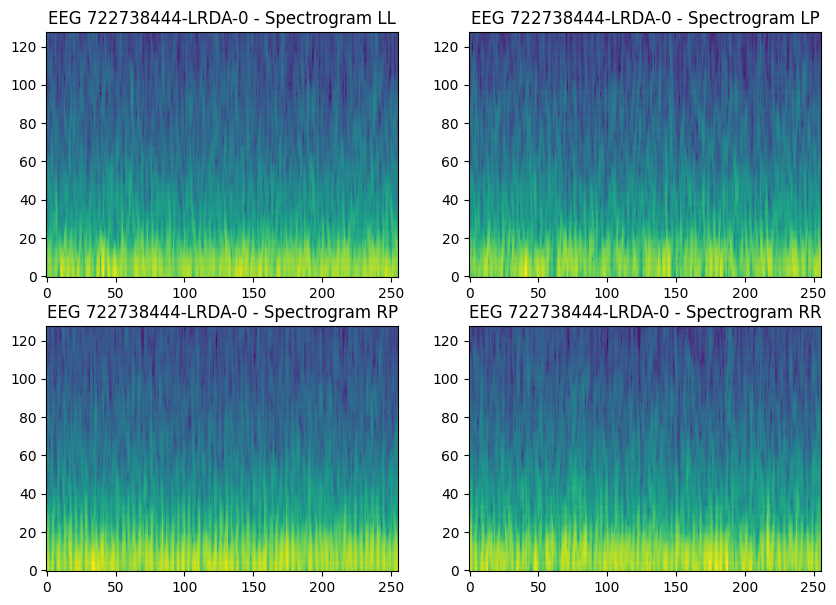

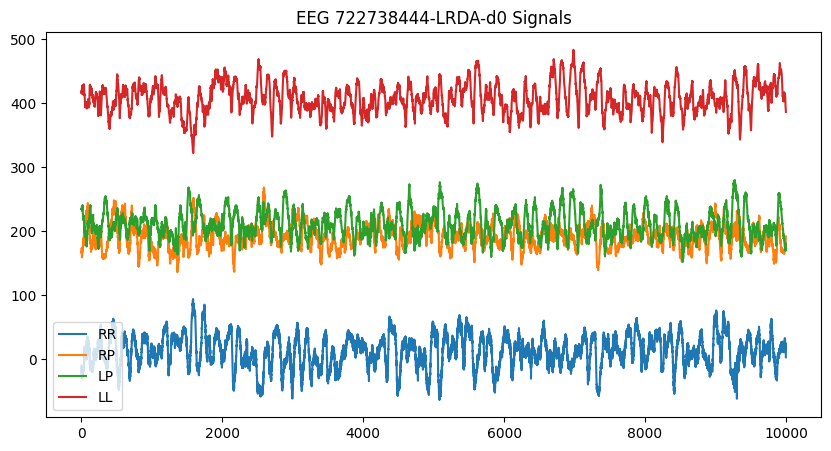


#########################



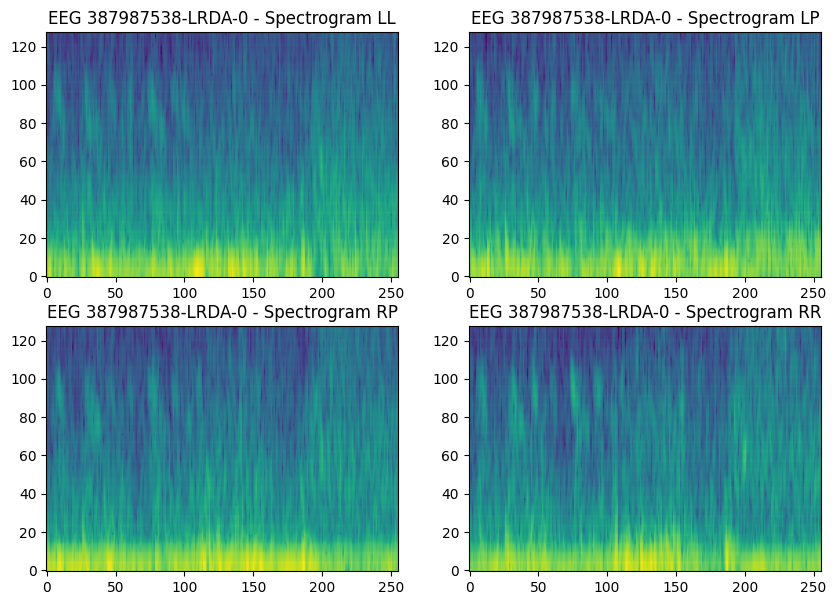

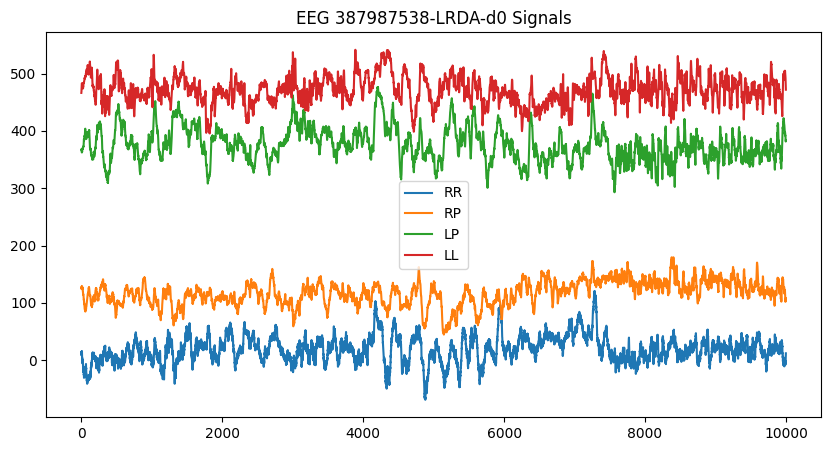


#########################

Creating and writing 22774 spectrograms to disk... CPU times: user 22.2 s, sys: 4.4 s, total: 26.6 s
Wall time: 21.3 s


In [15]:
%%time

if SAVE_INDIVIDUAL_EEGS:
    directory_path = 'EEG_Spectrograms/'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
DISPLAY = 4
all_eegs = {}

for i,(idx, row) in enumerate(train.iterrows()):
    if (i%100==0)&(i!=0): print(i,', ',end='')
    
    
    eeg_id = row['eeg_id']
    target = row['expert_consensus']
    d_count = row['dup_count']
    label = f'{eeg_id}-{target}-{d_count}'
    
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(row, i<DISPLAY)
    
    # SAVE TO DISK
    if i==DISPLAY:
        print(f'Creating and writing {train.shape[0]} spectrograms to disk... ',end='')
    
    if SAVE_INDIVIDUAL_EEGS:
        np.save(f'{directory_path}{label}',img)
    all_eegs[label] = img
    
    if not SAVE_EEGS and i == 4:
        break
   
# SAVE EEG SPECTROGRAM DICTIONARY
if SAVE_EEGS:
    np.save('eeg_specs',all_eegs)

# Visualize the created Dataset

In [16]:
EEG_VISUALIZE = True
if EEG_VISUALIZE:
    all_eegs = np.load('/kaggle/input/eeg-spectrogram-by-extended-data/eeg_specs.npy', 
                       allow_pickle=True).item()

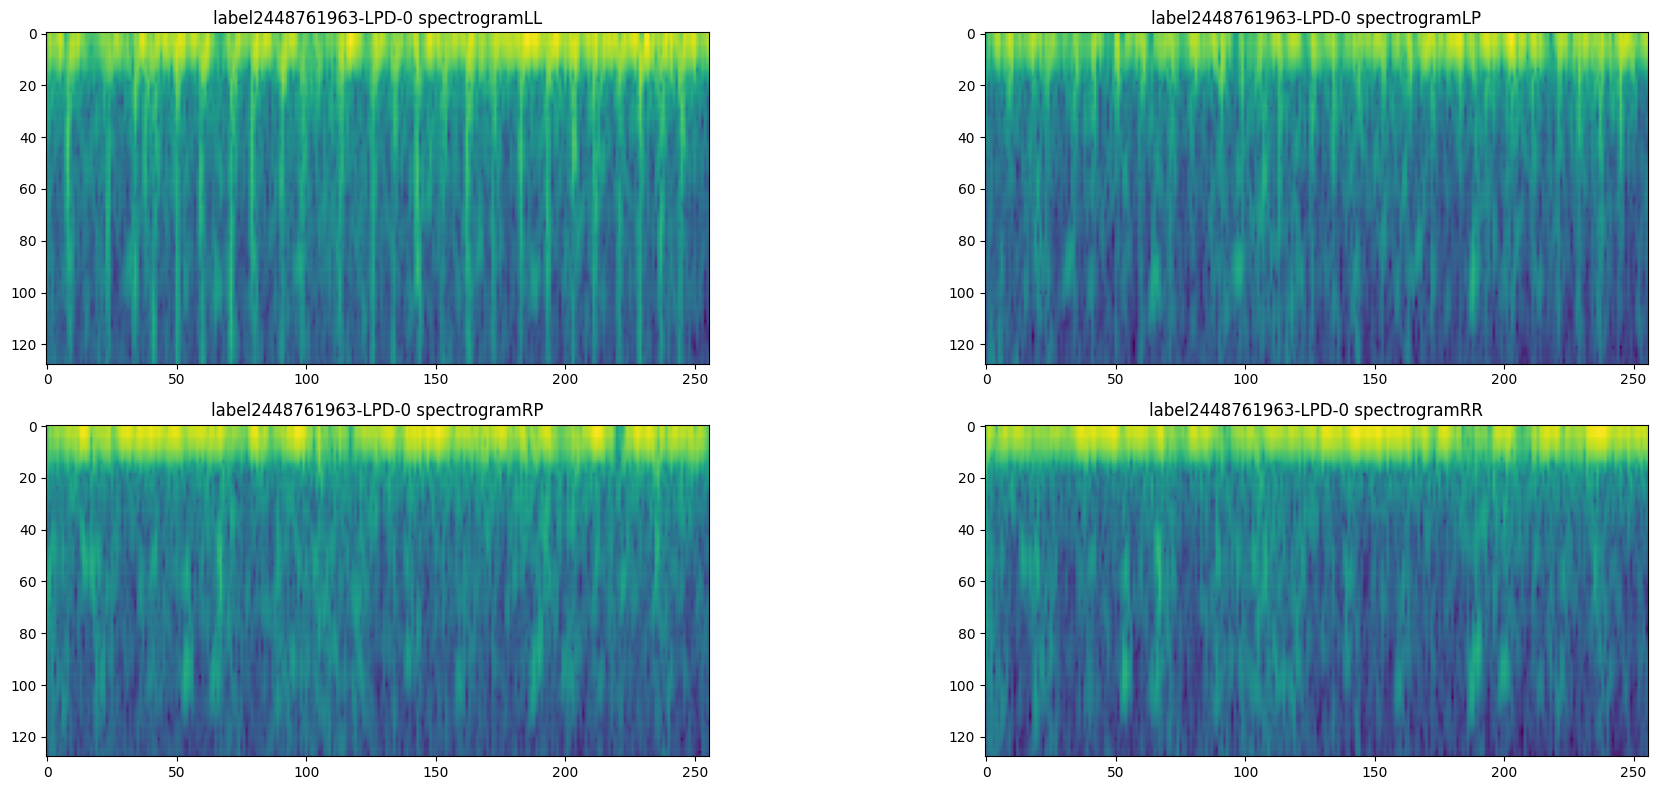

In [17]:
if EEG_VISUALIZE:
    sample_row = train.iloc[np.random.randint(0,train.shape[0])]

    eeg_id = sample_row['eeg_id']
    target = sample_row['expert_consensus']
    d_count = sample_row['dup_count']
    label = f'{eeg_id}-{target}-{d_count}'

    eeg_df = all_eegs[label]
    
    plt.figure(figsize=(20,8))
    for i in range(4):
        plt.subplot(2,2,i+1)
        img = eeg_df[:,:,i]
        plt.imshow(img)
        plt.title(f'label{label} spectrogram{NAMES[i]}')

    plt.tight_layout()
    